In [2]:
!wget https://samsclass.info/129S/proj/blur.zip
!unzip blur.zip

--2023-06-28 15:30:00--  https://samsclass.info/129S/proj/blur.zip
Resolving samsclass.info (samsclass.info)... 104.21.17.27, 172.67.219.198, 2606:4700:3036::ac43:dbc6, ...
Connecting to samsclass.info (samsclass.info)|104.21.17.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 555019181 (529M) [application/zip]
Saving to: ‘blur.zip’

blur.zip            100%[===================>] 529.31M   180MB/s    in 2.9s    

2023-06-28 15:30:03 (180 MB/s) - ‘blur.zip’ saved [555019181/555019181]

Archive:  blur.zip
   creating: blur/
   creating: blur/defocused_blurred/
  inflating: __MACOSX/blur/._defocused_blurred  
  inflating: blur/.DS_Store          
  inflating: __MACOSX/blur/._.DS_Store  
   creating: blur/sharp/
  inflating: __MACOSX/blur/._sharp   
  inflating: blur/defocused_blurred/216_ASUS-ZENFONE-LIVE-ZB501KL_F.jpg  
  inflating: __MACOSX/blur/defocused_blurred/._216_ASUS-ZENFONE-LIVE-ZB501KL_F.jpg  
  inflating: blur/defocused_blurred/0_IPHONE-SE_F.JPG  
 

100%|██████████| 350/350 [00:17<00:00, 20.02it/s]


6


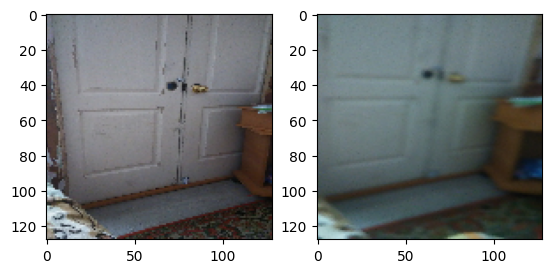

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import random
import cv2
import os
import tensorflow as tf
from tqdm import tqdm

good_frames = 'blur/sharp'
bad_frames = 'blur/defocused_blurred'

clean_frames = []
for file in tqdm(sorted(os.listdir(good_frames))):
    if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
        image = tf.keras.preprocessing.image.load_img(good_frames + '/' + file, target_size=(128,128))
        image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
        clean_frames.append(image)

clean_frames = np.array(clean_frames)
blurry_frames = []
for file in tqdm(sorted(os.listdir(bad_frames))):
    if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
        image = tf.keras.preprocessing.image.load_img(bad_frames + '/' + file, target_size=(128,128))
        image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
        blurry_frames.append(image)

blurry_frames = np.array(blurry_frames)

r = random.randint(0, len(clean_frames)-1)
print(r)
fig = plt.figure()
fig.subplots_adjust(hspace=0.1, wspace=0.2)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(clean_frames[r])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(blurry_frames[r])

In [4]:
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras import backend as K

seed = 21
random.seed = seed
np.random.seed = seed

x = clean_frames;
y = blurry_frames;
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(x_train[0].shape)
print(y_train[0].shape)

(128, 128, 3)
(128, 128, 3)


In [5]:
# Network Parameters
input_shape = (128, 128, 3)
batch_size = 32
kernel_size = 3
latent_dim = 256

# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [64, 128, 256]

inputs = Input(shape = input_shape, name = 'encoder_input')
x = inputs

for filters in layer_filters:
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               activation='relu',
               padding='same')(x)
shape = K.int_shape(x)
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 latent_vector (Dense)       (None, 256)               16777472  
                                                                 
Total params: 17,148,288
Trainable params: 17,148,288
Non-t

In [6]:
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
x = Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
for filters in layer_filters[::-1]:
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        activation='relu',
                        padding='same')(x)

outputs = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 65536)             16842752  
                                                                 
 reshape (Reshape)           (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 256)      590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 128, 128, 64)     7379

In [7]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

autoencoder.compile(loss='mse', optimizer='adam',metrics=["acc"])

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

callbacks = [lr_reducer]
history = autoencoder.fit(blurry_frames,
                      clean_frames,
                      validation_data=(blurry_frames, clean_frames),
                      epochs=5,
                      batch_size=batch_size,
                      callbacks=callbacks,
                      verbose=2)


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 encoder (Functional)        (None, 256)               17148288  
                                                                 
 decoder (Functional)        (None, 128, 128, 3)       17803395  
                                                                 
Total params: 34,951,683
Trainable params: 34,951,683
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
9/9 - 58s - loss: 0.0698 - acc: 0.6347 - val_loss: 0.0683 - val_acc: 0.6679 - lr: 0.0010 - 58s/epoch - 6s/step
Epoch 2/5
9/9 - 63s - loss: 0.0679 - acc: 0.6679 - val_loss: 0.0671 - val_acc: 0.6679 - lr: 0.0010 - 63s/epoch - 7s/step
Epoch 3/5
9/9 - 63s - loss: 0.0668 - acc: 0.6666 - val_loss: 0.06


       Input                        Ground Truth                  Predicted Value
1/1 [==============================] - 0s 87ms/step


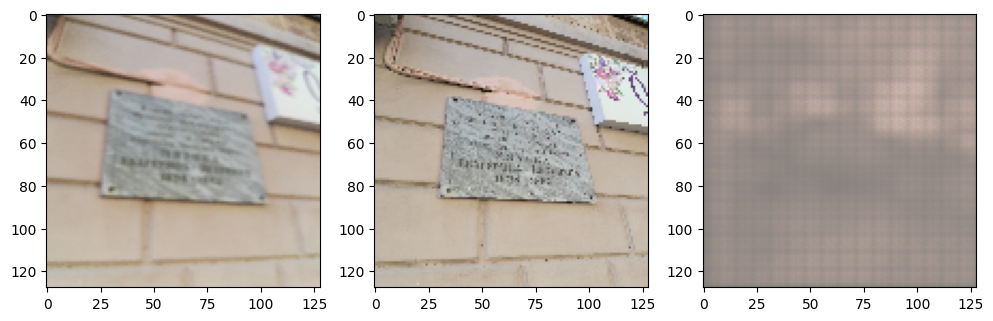

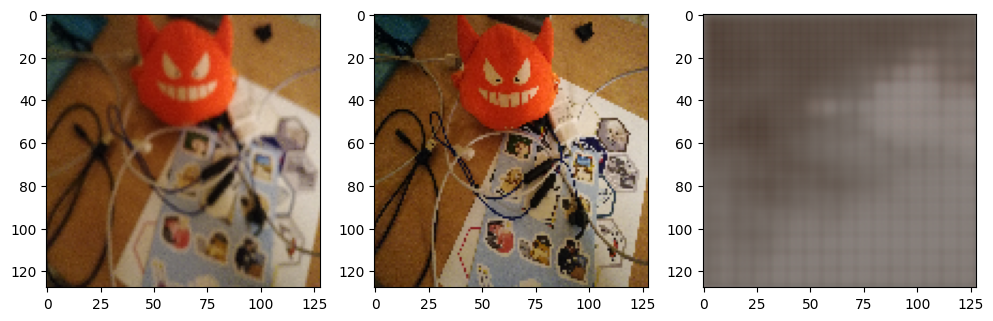

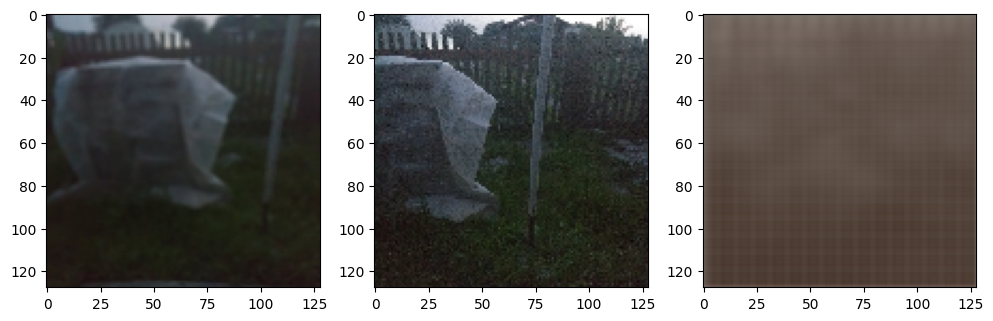

In [8]:
print("\n       Input                        Ground Truth                  Predicted Value")
for i in range(3):

    r = random.randint(0, len(clean_frames)-1)

    x, y = blurry_frames[r],clean_frames[r]
    x_inp=x.reshape(1,128,128,3)
    result = autoencoder.predict(x_inp)
    result = result.reshape(128,128,3)

    fig = plt.figure(figsize=(12,10))
    fig.subplots_adjust(hspace=0.1, wspace=0.2)

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x)

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(y)

    ax = fig.add_subplot(1, 3, 3)
    plt.imshow(result)

In [9]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

autoencoder.compile(loss='mse', optimizer='adam',metrics=["acc"])

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               verbose=1,
                               min_lr=0.5e-6)

callbacks = [lr_reducer]
history = autoencoder.fit(blurry_frames,
                      clean_frames,
                      validation_data=(blurry_frames, clean_frames),
                      epochs=100,
                      batch_size=batch_size,
                      callbacks=callbacks,
                      verbose=2)


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 encoder (Functional)        (None, 256)               17148288  
                                                                 
 decoder (Functional)        (None, 128, 128, 3)       17803395  
                                                                 
Total params: 34,951,683
Trainable params: 34,951,683
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
9/9 - 57s - loss: 0.0684 - acc: 0.6253 - val_loss: 0.0599 - val_acc: 0.6667 - lr: 0.0010 - 57s/epoch - 6s/step
Epoch 2/100
9/9 - 55s - loss: 0.0588 - acc: 0.6673 - val_loss: 0.0542 - val_acc: 0.6631 - lr: 0.0010 - 55s/epoch - 6s/step
Epoch 3/100
9/9 - 63s - loss: 0.0526 - acc: 0.6561 - val_loss